In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [2]:
"""IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50"""

'IMAGE_SIZE=256\nBATCH_SIZE=32\nCHANNELS=3\nEPOCHS=50'

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(256, 256),
    batch_size=32,
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [5]:
len(dataset)


68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())



(32, 256, 256, 3)
[1 1 0 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 2 0 1 0 0 0 1 2 0 1 1 0 0 1]


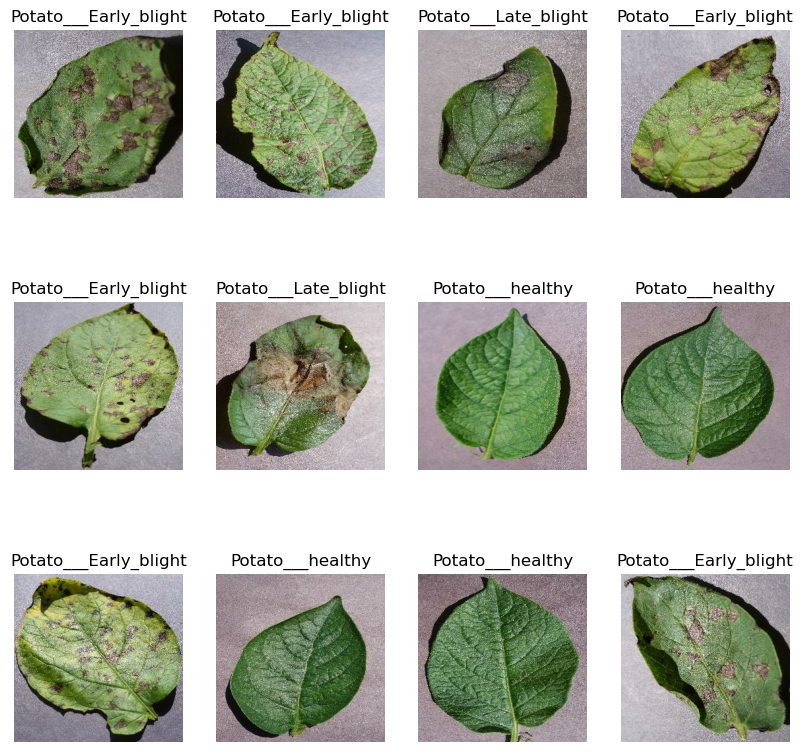

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])



In [8]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [11]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [14]:
def dataset_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = dataset_partition(dataset)

In [16]:
len(train_ds)

54

In [17]:
len(val_ds)

6

In [18]:
len(test_ds)

8

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(256, 256),
    tf.keras.layers.Rescaling(1.0/255)
])

In [21]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

"""    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidthZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeightZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomCrop(256, 256)"""


'    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),\n    tf.keras.layers.experimental.preprocessing.RandomWidthZoom(0.2),\n    tf.keras.layers.experimental.preprocessing.RandomHeightZoom(0.2),\n    tf.keras.layers.experimental.preprocessing.RandomCrop(256, 256)'

In [22]:
input_shape = (32, 256, 256, 3)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])
model.build(input_shape=input_shape)



In [23]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [24]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [25]:
history = model.fit(train_ds, 
          validation_data=val_ds, 
          epochs=50,
          batch_size=32,
          verbose=1)

Epoch 1/50
54/54 [==============================] - 26s 185ms/step - loss: 0.9257 - accuracy: 0.4850 - val_loss: 0.8462 - val_accuracy: 0.6146
Epoch 2/50
54/54 [==============================] - 8s 153ms/step - loss: 0.7454 - accuracy: 0.6250 - val_loss: 0.7547 - val_accuracy: 0.6667
Epoch 3/50
54/54 [==============================] - 8s 154ms/step - loss: 0.5330 - accuracy: 0.7674 - val_loss: 0.5197 - val_accuracy: 0.7969
Epoch 4/50
54/54 [==============================] - 8s 155ms/step - loss: 0.2956 - accuracy: 0.8692 - val_loss: 0.2119 - val_accuracy: 0.9219
Epoch 5/50
54/54 [==============================] - 9s 159ms/step - loss: 0.2660 - accuracy: 0.8987 - val_loss: 0.1596 - val_accuracy: 0.9323
Epoch 6/50
54/54 [==============================] - 10s 181ms/step - loss: 0.2596 - accuracy: 0.8929 - val_loss: 0.1716 - val_accuracy: 0.9323
Epoch 7/50
54/54 [==============================] - 9s 158ms/step - loss: 0.1645 - accuracy: 0.9387 - val_loss: 0.4171 - val_accuracy: 0.8646
Epoc

In [26]:
scores = model.evaluate(test_ds)


8/8 [==============================] - 2s 43ms/step - loss: 0.1252 - accuracy: 0.9688


In [27]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [28]:
history.history.keys()




dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
history.history['accuracy']



[0.48495370149612427,
 0.625,
 0.7673611044883728,
 0.8692129850387573,
 0.8987268805503845,
 0.8929398059844971,
 0.9386574029922485,
 0.9502314925193787,
 0.9490740895271301,
 0.9496527910232544,
 0.9571759104728699,
 0.9641203880310059,
 0.9820601940155029,
 0.9675925970077515,
 0.9537037014961243,
 0.9664351940155029,
 0.9704861044883728,
 0.9565972089767456,
 0.9855324029922485,
 0.9791666865348816,
 0.9571759104728699,
 0.9745370149612427,
 0.9855324029922485,
 0.9907407164573669,
 0.984375,
 0.9791666865348816,
 0.9797453880310059,
 0.9872685074806213,
 0.9820601940155029,
 0.9739583134651184,
 0.9872685074806213,
 0.9918981194496155,
 0.9884259104728699,
 0.9756944179534912,
 0.9803240895271301,
 0.9837962985038757,
 0.9971064925193787,
 0.9959490895271301,
 0.9924768805503845,
 0.9930555820465088,
 0.9959490895271301,
 0.9913194179534912,
 0.9930555820465088,
 0.9947916865348816,
 0.9849537014961243,
 0.9890046119689941,
 0.9890046119689941,
 0.9942129850387573,
 0.99826389551

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']





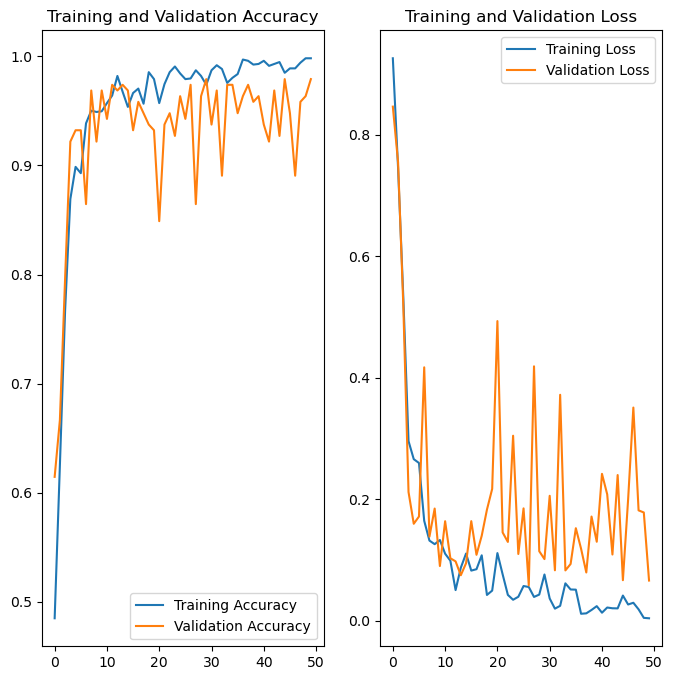

In [31]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


First image to predict
Actual lable:  Potato___Late_blight
1/1 [==============================] - 0s 137ms/step
Predicted lable:  Potato___Late_blight


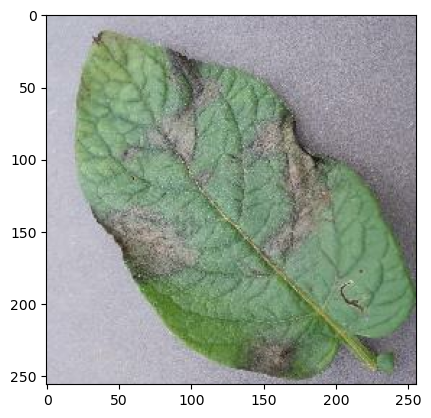

In [32]:
import numpy as np
for image_batch, label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy().astype("uint8"))
    first_lable = label_batch[0].numpy()

    print("First image to predict")

    plt.imshow(first_image)
    print("Actual lable: ", class_names[first_lable])
    #print(class_names[first_lable])

    batch_prediction = model.predict(image_batch)
    print("Predicted lable: ", class_names[np.argmax(batch_prediction[0])])




In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence




1/1 [==============================] - 0s 24ms/step


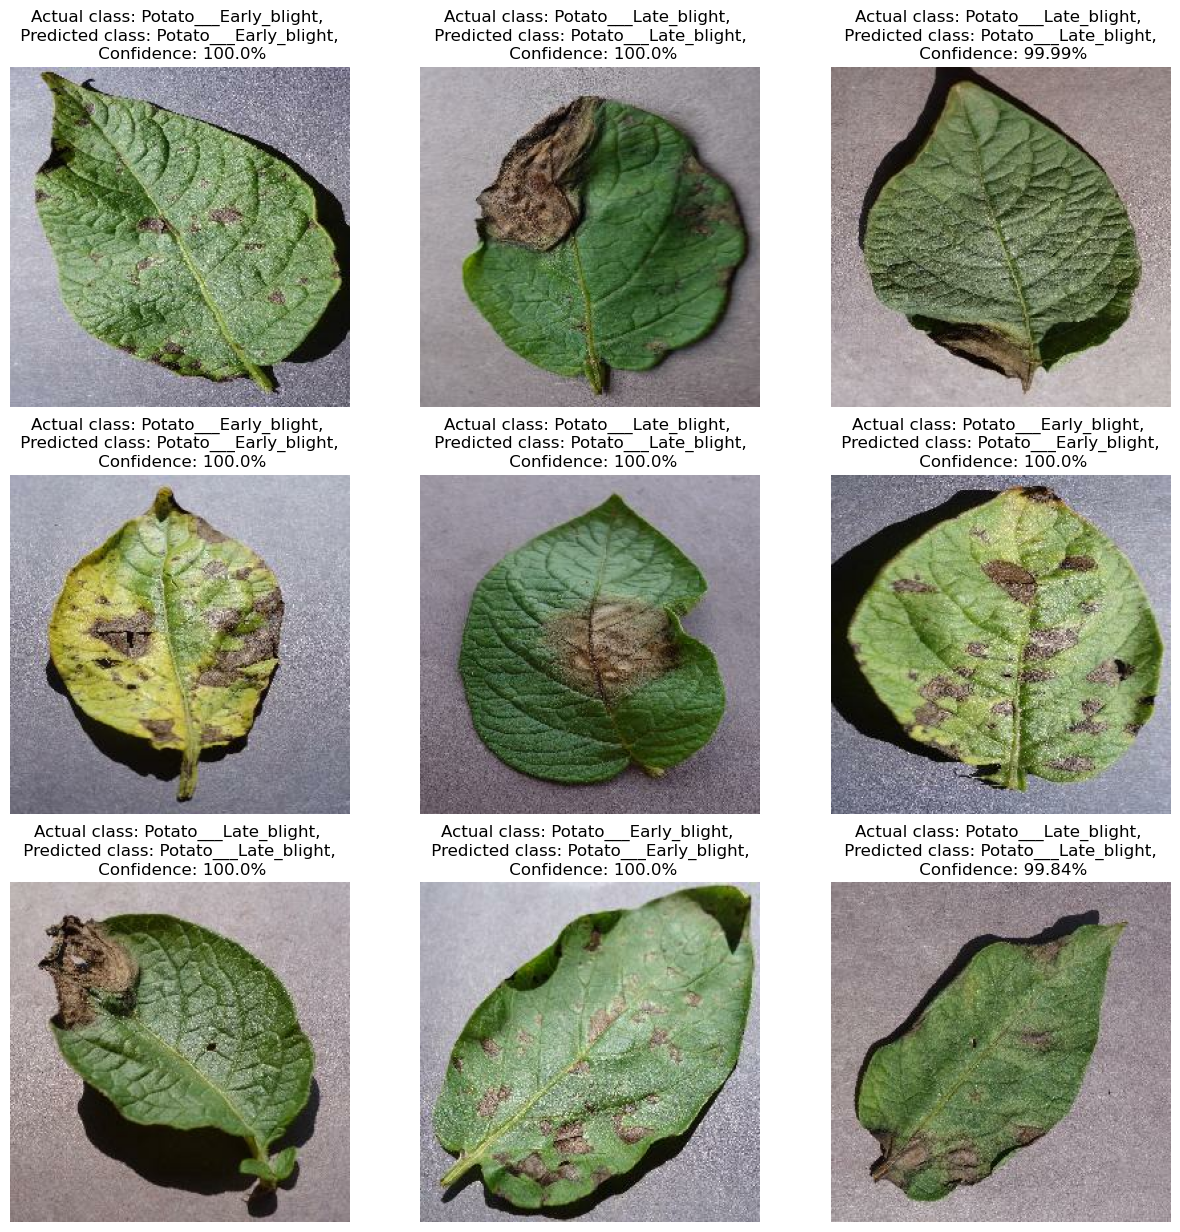

In [34]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]


        plt.title(f"Actual class: {actual_class}, \n Predicted class: {predicted_class}, \n Confidence: {confidence}%")
        plt.axis("off")




In [35]:
model_version = "Potato_Training_v1"
model.save(f"../Models/{model_version}")



INFO:tensorflow:Assets written to: ../Models/Potato_Training_v1\assets


INFO:tensorflow:Assets written to: ../Models/Potato_Training_v1\assets
